In [1]:
%matplotlib inline
import random
import mindspore as ms
import mindspore.ops as ops
from mindspore import Tensor
from d2l import mindspore as d2l

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = ops.normal((num_examples, len(w)), Tensor(0, ms.int32), Tensor(1, ms.int32))
    y = ops.matmul(X, w) + b
    y += ops.normal(y.shape, Tensor(0, ms.int32), Tensor(0.01, ms.float32))
    return X, y.reshape((-1, 1))

true_w = ms.Tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: [0.1829206  0.54930204] 
label: [2.6953428]


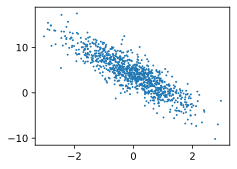

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = Tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.52709645 -1.1732943 ]
 [ 0.95233107 -0.995502  ]
 [ 1.2086309  -0.32991844]
 [ 0.9901913  -0.69030356]
 [ 0.47878307 -1.0795559 ]
 [-0.6719952   0.8325716 ]
 [-1.3360494   0.4516287 ]
 [-0.5432448  -0.5557819 ]
 [-0.9502959  -1.3601911 ]
 [ 1.0849547   0.27315724]] 
 [[9.2529163e+00]
 [9.5004816e+00]
 [7.7378578e+00]
 [8.5342941e+00]
 [8.8381844e+00]
 [4.3278717e-02]
 [1.5797084e-03]
 [4.9978504e+00]
 [6.9116750e+00]
 [5.4289927e+00]]


MindSpore的静态图思路是将整个模型视作一个完整的计算图，即模型、Loss、优化器均需要作为计算图的一部分。这与Pytorch的使用习惯有些不符。接下来将通过线性回归的例子来体现：

In [7]:
# 模型参数的初始化将在后续封装的模型内实现

import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal
from mindspore import grad

In [8]:
def linreg(x, w, b):
    return ops.matmul(x, w) + b

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [10]:
class sgd(nn.Cell):
    def __init__(self, lr, batch_size, params):
        super().__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.params = params
        
    def construct(self, grads):
        for idx in range(len(self.params)):
            ops.assign(self.params[idx], self.params[idx] - self.lr * grads[idx] / self.batch_size)
        return True

按照上面的叙述，需要讲模型和loss连接

定义模型，定义模型的参数，模型的输入输出。这里需要用到nn.Cell，因为只有这样才能够使编译器识别编译为计算图。

In [11]:
class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), ms.float32))
        self.b = Parameter(initializer(Zero(), 1, ms.float32))
        
    def construct(self, x, y):
        y_hat = linreg(x, self.w, self.b)
        loss = squared_loss(y_hat, y)
        return loss

训练过程。其实包括三步，分别为：

     1.计算正向结果
     2.计算反向梯度
     3.更新权重


In [24]:
lr = 0.03
num_epochs = 3
net = Net()
optim = sgd(lr, batch_size, net.trainable_params())
train = Train(net, optim)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 计算正向结果
        loss = net(X, y)
        # 计算反向梯度
        grad_fn = grad(net, grad_position=None, weights=optim.params)
        grads = grad_fn(X, y)
        # 更新权重
        loss = ops.depend(loss, optim(grads))
    train_l = net(features, labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

[Parameter (name=network.w, shape=(2, 1), dtype=Float32, requires_grad=True), Parameter (name=network.b, shape=(1,), dtype=Float32, requires_grad=True)]
epoch 1, loss 0.035977
epoch 2, loss 0.000134
epoch 3, loss 0.000046


In [14]:
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')

w的估计误差: [ 9.4294548e-05 -1.2683868e-04]
b的估计误差: [0.00012207]
